# Multi-Omic analysis

Given multiple datasets, each representing a different part of the chain between genomics and proteomics we 
seek to find biological pathways that drive or inhibit certain phenotypes.

The goal is to integrate these datasets such that the whole is more than the sum of the parts.

Ritchie et al. (Methods of integrating data to uncover genotype-phenotype interactions) describe the following ways to integrate multi-omic data

* Pathway or knowledge-based integration
* Concatenation-based: combine all datasets
* Model-based: create models per datasets, then combine models
* Transformation-based

We can also think of 
* Reduced normalised concatenation
* Model-based inter-omic transformation

Another subdivision is given by early, intermediate and late integration of omics with respect
to the identification of clusters/classes.

Per omic we collect important features, by
* comparing the non-parametric distributions over the different classifications
* simply counting the occurrences and setting a cut-off point
* using the importances of the classification models as filters
* checking the summed weights of linear and non-linear dimensionality reducers

We then have the choice to collect these features
*  greedily: all remaining omic features
*  non-greedily: only overlapping features (by gene)

To find inter **and** intra-omic connections we can resort to a similarity measure. 



## Tools 

A zoo of techniques exist:

* sparse CCA (sCCA)
* sparse ICA (sICA)
* sparse PLS (sPLS)
* sparse PCA (sPCA)
* multiple co-inertia analysis (MCIA)
* **Similarity Network Fusion (SNF)**
* **Multi-Omic Factor Analysis (MOFA)**
* joint-NMF (jNMF)
* iNMF
* Affinity Network Fusion (ANF)
* **Weighted Gene-Co expression Network Analysis (WGCNA)**
* joint graphical LASSO 
* Inter-battery factor analysis (IBFA)
* Cross-modal factor analysis (CFA)
* Joint and individual variation explained (JIVE)
* Redundancy analysis (RDA)
* Canonical Correspondence analysis
* Bayesian concensus clustering (BCC)
* joint Affinity Propagation
* iCluster
* PARADIGM
* NEMO
* T-SVD
* Multiple Dataset Integration (MDI)
* Pattern Fusion Analysis (PFA)
* Multiple Factor Analysis (MFA)


before we can appreciate these techniques and delf into them we first need to get some basic intuition of 
what multi-omics data means in practice.

# Basic intuition



## Similarity Network Fusion

Unsupervised. Meant for **disease sub-typing**. Mixing of patient clusters from different datasets.

![image](../_images/SimilarityNetworkFusion.png)

## Multi-omics Factor Analysis

Unsupervised. Meant for **pathway analysis** and multi-omics dimension reduction.

![image](../_images/mofa_overview.png)

## Weighted Gene-Co expression Network Analysis

Single-omics high-dimensional dimension reduction, through pairwise similarities. Extraction of eigengenes.
--> similar to Affinity Propagation and same parts of Markov Clustering but with fuzzy cluster assignment.

See WGCNA more as a suite of tools in R that aim to give a comprehensive overview of the correlations from the perspective of different ontologies.

![image](../_images/WGCNA.png)

In [167]:
import pandas as pd
from tqdm import tqdm
import os
from scipy import spatial
from scipy import sparse
import numpy as np
import gc
from matplotlib import pyplot as plt
import seaborn as sns
from numba import njit, jit

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances_chunked
import joblib

from umap import UMAP

In [ ]:
os.chdir('/media/bramiozo/DATA-FAST/genetic_expression')

In [141]:
def _iterative_cosine(X, min_corr=0.75, axis=1):   
    ran = X.shape[1-axis]
    for c1 in range(ran):
        for c2 in range(c1+1,ran): 
            v1 = X[:,c1]
            v2 = X[:,c2]
            similarity = np.inner(v1,v2)/np.linalg.norm(v1, ord=2)/np.linalg.norm(v2, ord=2)
            if abs(similarity)>min_corr:
                yield similarity, c1, c2
            
def _iterative_correlation(X, min_corr=0.75, axis=1):   
    ran = X.shape[1-axis]
    for c1 in range(ran):
        for c2 in range(c1+1,ran): 
            v1 = X[:,c1]
            v2 = X[:,c2]
            v1m = np.mean(v1)
            v2m = np.mean(v2)
            similarity = np.inner(v1-v1m,v2-v2m)/np.linalg.norm(v1-v1m, ord=2)/np.linalg.norm(v2-v2m, ord=2)
            if abs(similarity)>min_corr:
                yield similarity, c1, c2
                

def _iterative_self_correlator(X, min_corr=0.75, metric='cosine', axis=1):   
    ran = X.shape[1-axis]
    for c1 in range(ran):
        for c2 in range(c1+1,ran): 
            similarity = 1-spatial.distance.cdist(X[:,c1:c1+1].T, 
                                                X[:,c2:c2+1].T,
                                                metric)[0][0]
            if abs(similarity)>min_corr:
                yield similarity, c1, c2
                
def intra_correlator(X, min_corr=0.9, metric='cosine', axis=1):
    if metric=='cosine':
        get_corrs = _iterative_cosine(X, min_corr=min_corr, axis=axis)
    elif metric=='correlation':
        get_corrs = _iterative_correlation(X, min_corr=min_corr, axis=axis)
    else:
        get_corrs = _iterative_self_correlator(X, min_corr=min_corr, metric=metric, axis=axis)
        
    dv, c1v, c2v = [], [], []
    for _c in tqdm(get_corrs):
        dv.append(_c[0])
        c1v.append(_c[1])
        c2v.append(_c[2])
    return dv, c1v, c2v


# https://deepgraph.readthedocs.io/en/latest/tutorials/pairwise_correlations.html
# https://cupy.dev/

# Casus: lung cancer type differentiation

* Squamous cell carcinoma: 500 patients, age, gender
* Adenoma carcinoma: 500 patients, age, gender

The Cancer Genome Atlas. 

## Metadata

In [ ]:
Meta = pd.read_feather('hackathon_2/Lung_meta.feather')
Meta.set_index('SampleID', inplace=True)
print(Meta.shape)

In [142]:
samples_non_responders = Meta.loc[Meta.Response==0].index
samples_responders = Meta.loc[Meta.Response==1].index

samples_LSCC = Meta.loc[Meta.Diagnosis=='Lung Squamous Cell Carcinoma'].index
samples_ADENO = Meta.loc[Meta.Diagnosis=='Lung Adenocarcinoma'].index

In [87]:
Methylation_Meta = pd.read_csv('hackathon_2/Lung/HumanMethylation450_meta.csv', sep=',', engine='python')
Methylation_Meta_Map = Methylation_Meta[['IlmnID', 'Name', 'UCSC_RefGene_Name', 'UCSC_RefGene_Accession',
                                         'UCSC_RefGene_Group']]
del Methylation_Meta

## DNA mutation

In [178]:
mutation = pd.read_feather('hackathon_2/Lung_mutation.feather')
mutation.set_index('Sample_ID', inplace=True)

## DNA Copy Number Variation

In [ ]:
CNV = pd.read_feather('hackathon_2/Lung_CNV.feather')
CNV.set_index('index', inplace=True)
print(CNV.shape)

## RNA expression

In [139]:
RNAex=pd.read_feather('hackathon_2/Lung_RNAex.feather')
RNAex.set_index('index', inplace=True)
RNAex_cols_all = RNAex.columns.tolist()
print(RNAex.shape)
keep_cols = RNAex.columns[(RNAex.mean()>0.1)]

(1135, 60465)


In [ ]:
'''
r = 0.5
def corr_filter(chunk, start):
    neigh = [np.flatnonzero(d > r) for d in chunk]
    avg_dist = (chunk * (chunk > r)).mean(axis=1)
    return neigh, avg_dist
    
gen = pairwise_distances_chunked(RNAex.loc[:,keep_cols].T.values,
                           reduce_func=corr_filter,
                           metric=spatial.distance.cosine,
                           working_memory=1,
                           n_jobs=16)

ir, jr, avg_dists = [], set(), []
for i,d in tqdm(enumerate(gen)):
    ir.append(i)
    jr.add(set(list(d[0])))
    avg_dists.extend(d[1])
'''

In [ ]:
# https://umap-learn.readthedocs.io/en/latest/sparse.html
# Sparse UMAP

In [145]:
# correlation custom 1586 - 41.15 it/s
# correlation scipy 1507 - 60 it/s
# correlation sklearn 
RNAex_responders = RNAex.loc[RNAex.index.isin(samples_responders)]
#keep_cols = RNAex.columns[(RNAex_responders.mean()>1)]

RNAex_norm = StandardScaler().fit_transform(RNAex_responders.loc[:,keep_cols])
scorr_responder, ir_responder, jr_responder = intra_correlator(RNAex_norm, 
                                                               min_corr=0.55, 
                                                               metric='correlation', 
                                                               axis=0)
gc.collect()

72823it [5:57:12,  3.40it/s] 


48

In [146]:
RNAex_nresponders = RNAex.loc[RNAex.index.isin(samples_non_responders)]
#keep_cols = RNAex.columns[(RNAex_nresponders.mean()>1)]

RNAex_norm = StandardScaler().fit_transform(RNAex_nresponders.loc[:,keep_cols])
scorr_nresponder, ir_nresponder, jr_nresponder = intra_correlator(RNAex_norm, 
                                                               min_corr=0.55, 
                                                               metric='correlation', 
                                                               axis=0)
gc.collect()

67520it [6:18:16,  2.97it/s] 


20

In [147]:
RNAex_norm = StandardScaler().fit_transform(RNAex.loc[:,keep_cols])
scorr_gen, ir_gen, jr_gen = intra_correlator(RNAex_norm, min_corr=0.55, metric='correlation', axis=0)
gc.collect()

708714it [6:27:10, 30.51it/s]  


20

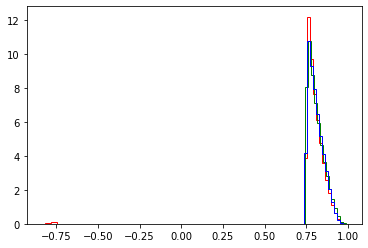

In [148]:
plt.hist(scorr_responder, bins=100, histtype='step', color='r', density=True);
plt.hist(scorr_nresponder, bins=100, histtype='step', color='g', density=True);
plt.hist(scorr_gen, bins=100, histtype='step', color='b', density=True);

In [149]:
print(f'We have {len(scorr_responder)}, {len(scorr_nresponder)}, and {len(scorr_gen)} nodes, for the responders, \
non-responders and all')

We have 72823, 67520, and 708714 nodes, for the responders, non-responders and all


In [150]:
len(scorr_responder), len(ir_responder), len(jr_responder)

(72823, 72823, 72823)

In [151]:
RNAcoex_responder_sparse = sparse.coo_matrix((scorr_responder, (ir_responder,jr_responder)))
RNAcoex_nresponder_sparse = sparse.coo_matrix((scorr_nresponder, (ir_nresponder,jr_nresponder)))
RNAcoex_gen_sparse = sparse.coo_matrix((scorr_gen, (ir_gen,jr_gen)))

In [152]:
joblib.dump(RNAcoex_gen_sparse, 'hackathon_2/network_analysis/Lung/RNAex_coex_general.pkl')
joblib.dump(RNAcoex_nresponder_sparse, 'hackathon_2/network_analysis/Lung/RNAex_coex_nresponder.pkl')
joblib.dump(RNAcoex_responder_sparse, 'hackathon_2/network_analysis/Lung/RNAex_coex_responder.pkl')
RNAex.loc[:, keep_cols].reset_index().to_feather('hackathon_2/network_analysis/Lung/RNAex_meanGT1.feather')

In [176]:
reducer_umap = UMAP(n_components=2)
gen_reduced = reducer_umap.fit_transform(RNAex.loc[:, keep_cols[ir_nresponder]])

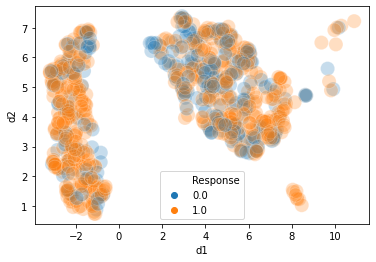

In [175]:
plot_df = pd.DataFrame(data=gen_reduced, index=RNAex.index, columns=['d1', 'd2'])
plot_df = plot_df.join(Meta[['Response']])
sns.scatterplot(data=plot_df, x='d1', y='d2', hue='Response', alpha=0.25, s=200)

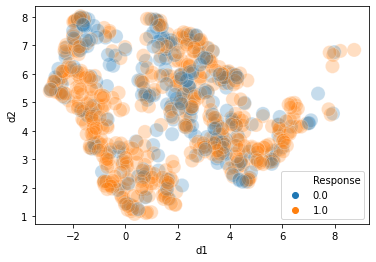

In [177]:
plot_df = pd.DataFrame(data=gen_reduced, index=RNAex.index, columns=['d1', 'd2'])
plot_df = plot_df.join(Meta[['Response']])
sns.scatterplot(data=plot_df, x='d1', y='d2', hue='Response', alpha=0.25, s=200)

In [ ]:
# minibatch sparse PCA on feature-feature, fastICA, sparse AP, sparse MCL

## microRNA

In [ ]:
mRNA=pd.read_feather('hackathon_2/Lung_mRNA.feather')
mRNA.set_index('index', inplace=True)
print(mRNA.shape)

## Methylation

In [5]:
methylation=pd.read_feather('hackathon_2/Lung_methylation.feather')
methylation.set_index('index', inplace=True)
print(methylation.shape)

(907, 311381)


In [15]:
from sklearn.linear_model import LassoCV

In [25]:
D = methylation.join(Meta.dropna(subset=['Age At Diagnosis (Days)'])\
                         [['Age At Diagnosis (Days)']]['Age At Diagnosis (Days)'],\
                                how='inner')
Ym = D['Age At Diagnosis (Days)']
Xm = D.loc[:, [c for c in D.columns if c!='Age At Diagnosis (Days)']]

lasser = LassoCV(normalize=True)
lasser.fit(X=Xm, y=Ym)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [51]:
positive_corr_probes = list(D.columns[np.argwhere(lasser.coef_>0)][:,0])
negative_corr_probes = list(D.columns[np.argwhere(lasser.coef_<0)][:,0])

<ipython-input-51-297726e883e0>:1: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  positive_corr_probes = list(D.columns[np.argwhere(lasser.coef_>0)][:,0])
<ipython-input-51-297726e883e0>:2: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  negative_corr_probes = list(D.columns[np.argwhere(lasser.coef_<0)][:,0])


In [74]:
lasso_age_probes = pd.DataFrame({'probe': D.columns[np.argwhere(np.abs(lasser.coef_)>0)][:,0],
                                 'coeff':lasser.coef_[np.argwhere(np.abs(lasser.coef_)>0)[:,0]]})
lasso_age_probes.set_index('probe', inplace=True)
Methylation_Meta_Map.set_index('IlmnID', inplace=True)
lasso_age_probes = lasso_age_probes.join(Methylation_Meta_Map[['UCSC_RefGene_Name']])

<ipython-input-74-54d19cc651ba>:1: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lasso_age_probes = pd.DataFrame({'probe': D.columns[np.argwhere(np.abs(lasser.coef_)>0)][:,0],


Pearson: 0.9188182763060878


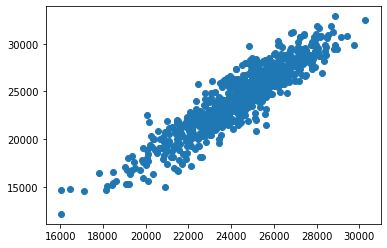

In [159]:
print('Pearson:', np.corrcoef(lasser.predict(X=Xm), Ym)[0,1])
plt.scatter(lasser.predict(X=Xm), Ym)

In [161]:
lasso_age_probes.to_csv('lasso_methylation_clock.csv', index=True, sep=";")

## Proteomics


In [ ]:
Proteome = pd.read_feather('hackathon_2/Lung_proteome.feather')
Proteome.set_index('index', inplace=True)
print(Proteome.shape)

# Multi-omics analysis

## reduction

## concatenation

## SNF 
[SNF](https://github.com/rmarkello/snfpy)

## MOFA

[MOFA2](https://github.com/bioFAM/MOFA2)

## Discussion